<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_6/34_GP_%26_sGP_beyond_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/utkarshp1161/Active-learning-in-microscopy/blob/main/notebooks/GP_&_sGP_beyond_1D.ipynb)
# GP and sGP in beyond 1 dimensions with Scalar Output using GPyTorch and BoTorch

This notebook demonstrates implementation of Gaussian Process regression for N-dimensional inputs with scalar outputs, using GPyTorch for GP modeling and BoTorch for Bayesian Optimization.

- Rewritten in Gpytorch and Botorch by [Utkarsh Pratiush](https://github.com/utkarshp1161). Inspired from [Original implementation in Gpax](https://github.com/SergeiVKalinin/ACerS_AE_2024/blob/main/12_GPax_beyond_1D.ipynb) by [Maxim Ziatdinov](https://github.com/ziatdinovmax) and [SVK](https://github.com/SergeiVKalinin).

## Key Features:
- N-dimensional input space handling
- Custom mean and kernel functions
- Bayesian Optimization with Upper Confidence Bound (UCB)
- Visualization for 1D and 2D cases



Note: For optimal performance, running on a GPU is recommended for high-dimensional problems.

## 1a. Install and Imports

In [ ]:
#install
!pip install -q botorch==0.12.0
!pip install -q gpytorch==1.13

# Imports
import torch
import gpytorch
import botorch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf_discrete
from botorch.acquisition import UpperConfidenceBound


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1b. Ground truth function

In [ ]:
# Define test function
def test_function(X, ndim=2):
    """
    Branin-like function generalized to n dimensions
    Args:
        X: Input tensor of shape (n_points, ndim)
        ndim: Number of input dimensions
    Returns:
        Y: Output tensor of shape (n_points, 1)
    """
    if ndim == 1:
        return (X[:, 0]**2 - 10*torch.cos(2*np.pi*X[:, 0]) + 10).unsqueeze(-1)

    # For higher dimensions, sum of modified Branin functions
    y = torch.zeros(X.shape[0], 1)
    for i in range(0, ndim-1, 2):
        x1, x2 = X[:, i], X[:, i+1]
        term1 = x2 - 5.1/(4*np.pi**2)*x1**2 + 5/np.pi*x1 - 6
        term2 = 10*(1-1/(8*np.pi))*torch.cos(x1)
        y = y + (term1**2 + term2 + 10).unsqueeze(-1)
    return y

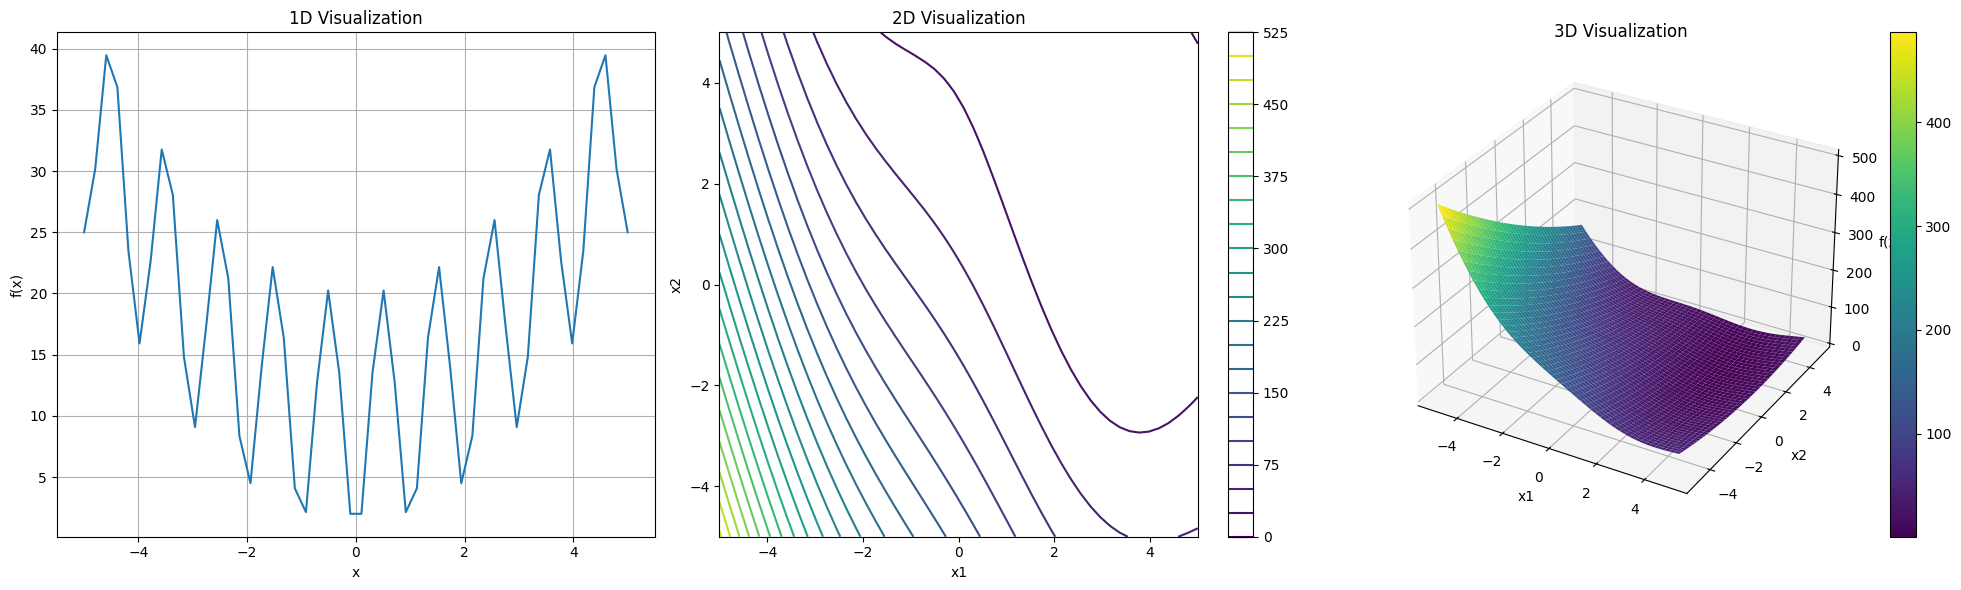

In [ ]:
def visualize_ground_truth_function(func, ndim=2, resolution=50):
    """
    Visualize function in 1D, 2D, and 3D side by side
    """
    plt.figure(figsize=(20, 6))

    # 1D Visualization
    plt.subplot(131)
    x = np.linspace(-5, 5, resolution)
    y = func(torch.tensor(x.reshape(-1, 1)).float(), ndim=1)
    plt.plot(x, y)
    plt.title("1D Visualization")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)

    # 2D Visualization
    plt.subplot(132)
    x = np.linspace(-5, 5, resolution)
    y = np.linspace(-5, 5, resolution)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack((X.flatten(), Y.flatten()))
    Z = func(torch.tensor(points).float())
    Z = Z.reshape(resolution, resolution).numpy()

    plt.contour(X, Y, Z, levels=20)
    plt.colorbar()
    plt.title("2D Visualization")
    plt.xlabel("x1")
    plt.ylabel("x2")

    # 3D Visualization
    ax = plt.subplot(133, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    plt.colorbar(surf)
    ax.set_title("3D Visualization")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x)")

    plt.tight_layout()
    plt.show()



# Visualize
visualize_ground_truth_function(test_function)

## 1c. Define kernel
- For more information on defining kernel - see [this notebook](https://github.com/utkarshp1161/Active-learning-in-microscopy/blob/main/notebooks/GP_%26_sGP_BO_BoTorch.ipynb)

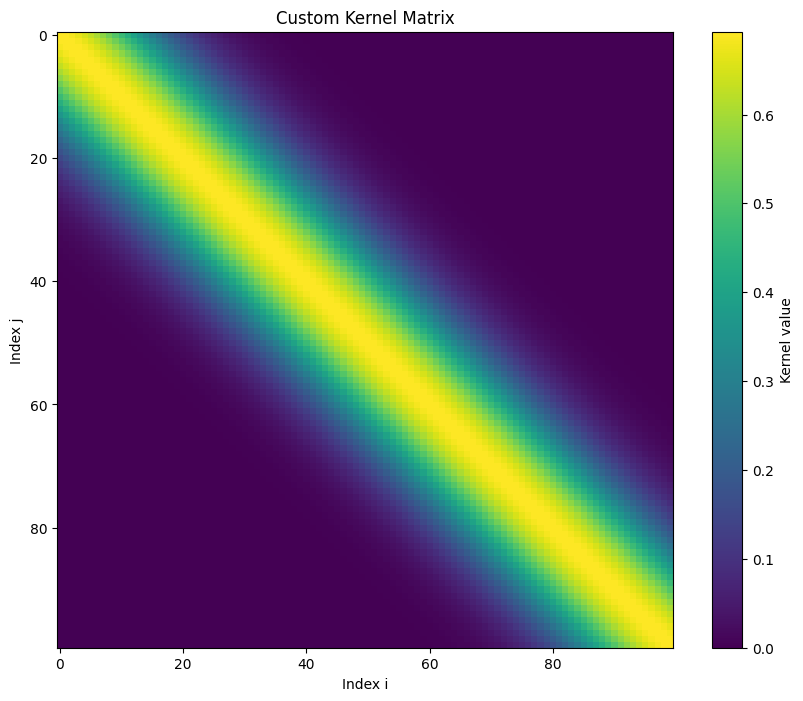

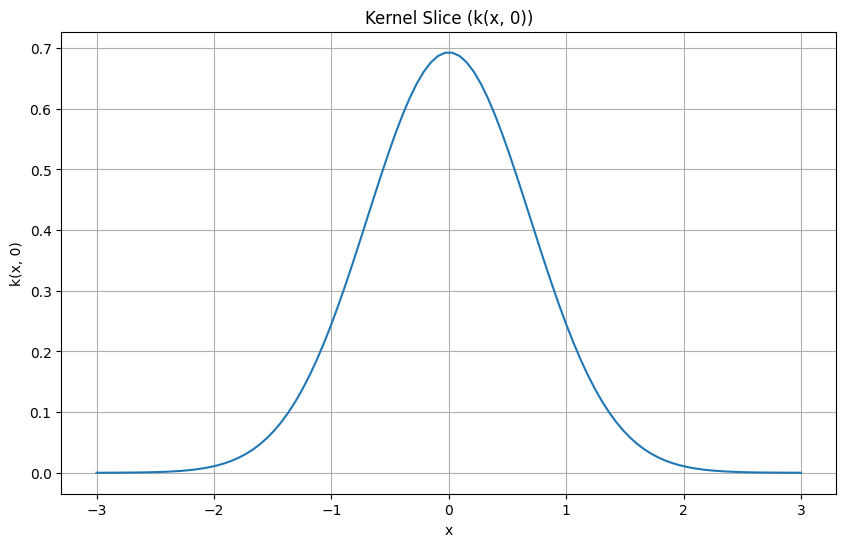

In [ ]:
## kernel
# Define the custom kernel
class CustomKernel(gpytorch.kernels.Kernel):
    def __init__(self, input_dim, lengthscale_prior=None, outputscale_prior=None):
        super().__init__()
        self.base_kernel = gpytorch.kernels.RBFKernel(
            ard_num_dims=input_dim,
            lengthscale_prior=lengthscale_prior
        )
        self.scaling_kernel = gpytorch.kernels.ScaleKernel(
            self.base_kernel,
            outputscale_prior=outputscale_prior
        )

    def forward(self, x1, x2, **params):
        return self.scaling_kernel.forward(x1, x2, **params)

# Create sample data
x = torch.linspace(-3, 3, 100).view(-1, 1)
kernel = CustomKernel(input_dim=1)

# Compute kernel matrix
K = kernel(x, x).evaluate().detach().numpy()

# Plot the kernel matrix
plt.figure(figsize=(10, 8))
plt.imshow(K, cmap='viridis')
plt.colorbar(label='Kernel value')
plt.title('Custom Kernel Matrix')
plt.xlabel('Index i')
plt.ylabel('Index j')
plt.show()

# Plot a slice of the kernel
x0 = torch.zeros(1, 1)
k_slice = kernel(x, x0).evaluate().detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), k_slice)
plt.title('Kernel Slice (k(x, 0))')
plt.xlabel('x')
plt.ylabel('k(x, 0)')
plt.grid(True)
plt.show()

## 1d. GP model

In [ ]:
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean

class SimpleGP(SingleTaskGP):
    def __init__(self, train_X, train_Y, covar_module, likelihood):
        super().__init__(train_X, train_Y)
        self.mean_module = ConstantMean()  # Constant mean function
        self.covar_module = covar_module
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Sample points function remains the same
def sample_points(ndim, n_points, bounds=(-5, 5)):
    return torch.rand(n_points, ndim) * (bounds[1] - bounds[0]) + bounds[0]

## 1e. Plotting utility

In [ ]:
def plot_step(model, train_X, train_Y, next_point=None, ndim=2):
    """Plot current state of optimization"""
    if ndim > 2:
        print("Visualization only supported for 1D and 2D inputs")
        return

    if ndim == 2:
        # Create meshgrid
        x1 = torch.linspace(train_X[:, 0].min(), train_X[:, 0].max(), 100)
        x2 = torch.linspace(train_X[:, 1].min(), train_X[:, 1].max(), 100)
        x1_grid, x2_grid = torch.meshgrid(x1, x2)
        grid_points = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=-1)

        # Get predictions
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            posterior = model.posterior(grid_points)
            mean = posterior.mean.squeeze()  # Add squeeze to handle single-output case
            lower, upper = posterior.confidence_region()

        # Reshape for plotting
        mean_surface = mean.reshape(100, 100)
        std_surface = ((upper - lower) / 2).reshape(100, 100)
        true_values = test_function(grid_points, ndim).reshape(100, 100)

        # Create plots
        fig = plt.figure(figsize=(15, 5))

        # True function
        ax1 = fig.add_subplot(131)
        c1 = ax1.contourf(x1_grid, x2_grid, true_values, levels=20)
        plt.colorbar(c1, ax=ax1)
        ax1.set_title('True Function')
        ax1.scatter(train_X[:, 0], train_X[:, 1], c='red', marker='x', label='Training points')
        if next_point is not None and next_point.numel() > 0:  # Check if next_point exists and is not empty
            ax1.scatter(next_point[0, 0], next_point[0, 1], c='green', marker='o', label='Next point')
        ax1.legend()

        # Posterior mean
        ax2 = fig.add_subplot(132)
        c2 = ax2.contourf(x1_grid, x2_grid, mean_surface, levels=20)
        plt.colorbar(c2, ax=ax2)
        ax2.set_title('Posterior Mean')
        ax2.scatter(train_X[:, 0], train_X[:, 1], c='red', marker='x')
        if next_point is not None and next_point.numel() > 0:
            ax2.scatter(next_point[0, 0], next_point[0, 1], c='green', marker='o')

        # Posterior std
        ax3 = fig.add_subplot(133)
        c3 = ax3.contourf(x1_grid, x2_grid, std_surface, levels=20)
        plt.colorbar(c3, ax=ax3)
        ax3.set_title('Posterior Std Dev')
        ax3.scatter(train_X[:, 0], train_X[:, 1], c='red', marker='x')
        if next_point is not None and next_point.numel() > 0:
            ax3.scatter(next_point[0, 0], next_point[0, 1], c='green', marker='o')

        plt.tight_layout()
        plt.show()

    elif ndim == 1:
        x_plot = torch.linspace(train_X.min(), train_X.max(), 100).reshape(-1, 1)

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            posterior = model.posterior(x_plot)
            mean = posterior.mean.squeeze()
            lower, upper = posterior.confidence_region()

        plt.figure(figsize=(10, 6))
        plt.plot(x_plot.numpy(), mean.numpy(), 'b-', label='Posterior Mean')
        plt.fill_between(x_plot.numpy().flatten(),
                        lower.numpy(),
                        upper.numpy(),
                        alpha=0.2,
                        label='95% Confidence')
        plt.scatter(train_X.numpy(), train_Y.numpy(), c='red',
                    marker='x', label='Training Points')
        if next_point is not None and next_point.numel() > 0:
            next_y = test_function(next_point, ndim)
            plt.scatter(next_point.numpy(), next_y.numpy(),
                       c='green', marker='o', label='Next point')
        plt.legend()
        plt.title('GP Posterior')
        plt.show()

## 1f. Training GP

<ipython-input-5-47a78b264c2b>:6: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


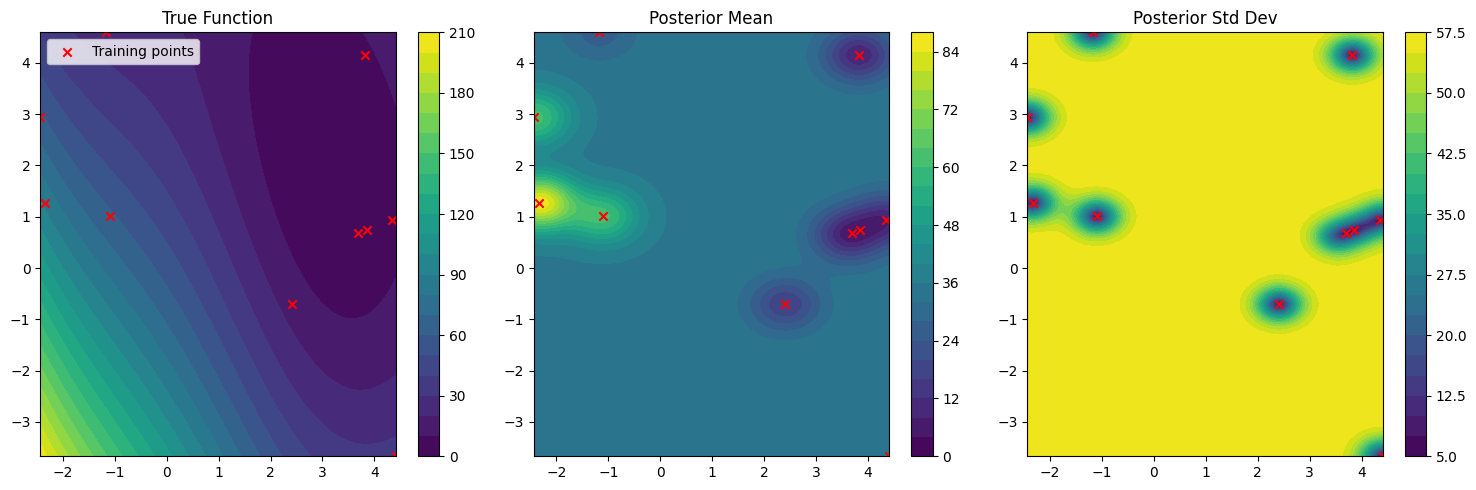

In [ ]:
# Main execution
if __name__ == "__main__":
    # Parameters
    ndim = 2
    n_initial = 10
    n_test = 100

    # Generate initial data
    train_X = sample_points(ndim, n_initial)
    train_Y = test_function(train_X, ndim)

    # Define priors
    lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0)
    outputscale_prior = gpytorch.priors.GammaPrior(2.0, 0.15)
    noise_prior = gpytorch.priors.GammaPrior(1.1, 0.05)

    # Define model components
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior)
    covar_module = CustomKernel(
        ndim,
        lengthscale_prior=lengthscale_prior,
        outputscale_prior=outputscale_prior
    )

    # Initialize and fit model
    model = SimpleGP(train_X, train_Y, covar_module, likelihood)
    mll = ExactMarginalLogLikelihood(likelihood, model)
    fit_gpytorch_mll(mll)

    plot_step(model, train_X, train_Y.squeeze(-1), next_point=None, ndim=ndim)  # Squeeze for plotting


# 2 sGP - with mean function prior
- Good idea to visit [this sGP notebook first](https://github.com/utkarshp1161/Active-learning-in-microscopy/blob/main/notebooks/GP_%26_sGP_BO_BoTorch.ipynb)

## 2a. Define cusom mean and sGP model

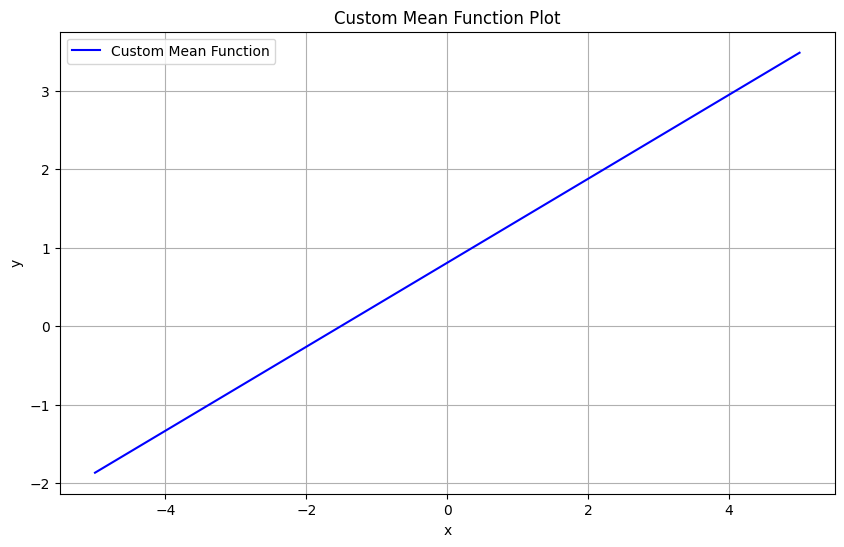

In [ ]:
# Custom mean function
class CustomMean(gpytorch.means.Mean):
    def __init__(self, input_size):
        super().__init__()
        self.constant = gpytorch.means.ConstantMean()
        self.linear = gpytorch.means.LinearMean(input_size)

    def forward(self, x):
        return self.constant(x) + self.linear(x)
# Create some test data
x = torch.linspace(-5, 5, 100).unsqueeze(-1)

# Initialize the custom mean function
mean_function = CustomMean(input_size=1)

# Get predictions
with torch.no_grad():
    y_pred = mean_function(x)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), y_pred.numpy(), 'b-', label='Custom Mean Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Custom Mean Function Plot')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# GP Model
class CustomGP(SingleTaskGP):
    def __init__(self, train_X, train_Y, mean_module, covar_module, likelihood):
        super().__init__(train_X, train_Y)
        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


## 2b. Training sGP

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


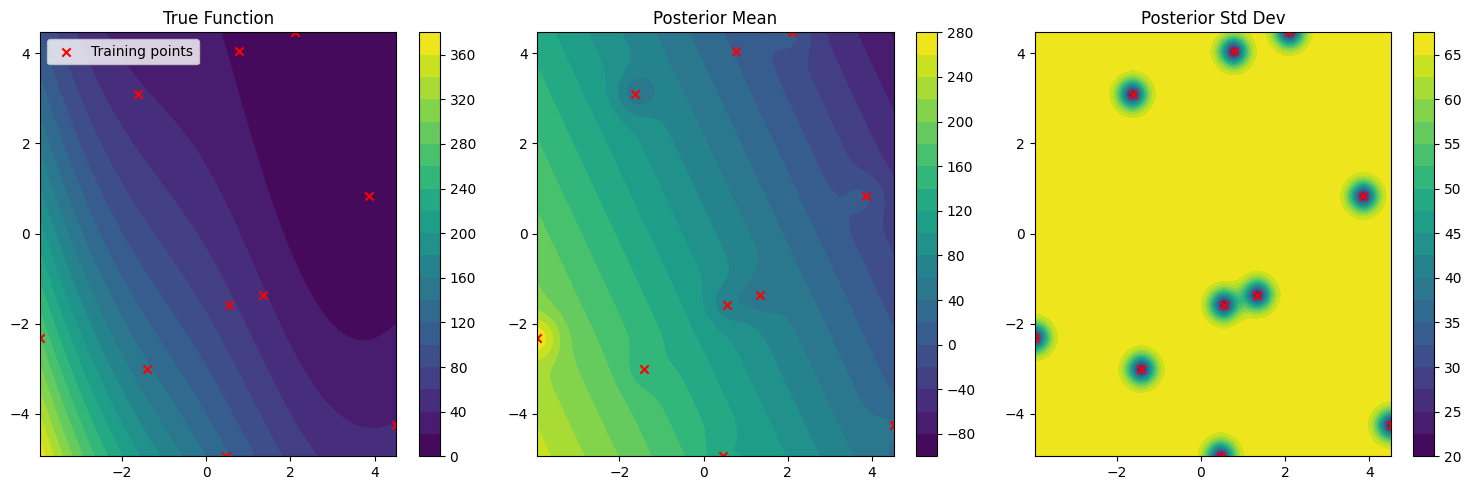

In [ ]:
# Parameters
ndim = 2
n_initial = 10
n_test = 100

# Generate initial data
train_X = sample_points(ndim, n_initial)
train_Y = test_function(train_X, ndim)

# Define priors
lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0)
outputscale_prior = gpytorch.priors.GammaPrior(2.0, 0.15)
noise_prior = gpytorch.priors.GammaPrior(1.1, 0.05)

# Define model components
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior)
mean_module = CustomMean(ndim)
covar_module = CustomKernel(
    ndim,
    lengthscale_prior=lengthscale_prior,
    outputscale_prior=outputscale_prior
)

# Initialize and fit model
model = CustomGP(train_X, train_Y, mean_module, covar_module, likelihood)
mll = ExactMarginalLogLikelihood(likelihood, model)
fit_gpytorch_mll(mll)
plot_step(model, train_X, train_Y.squeeze(-1), ndim=ndim)  # Squeeze for plotting



# 3. Active learning with sGP

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


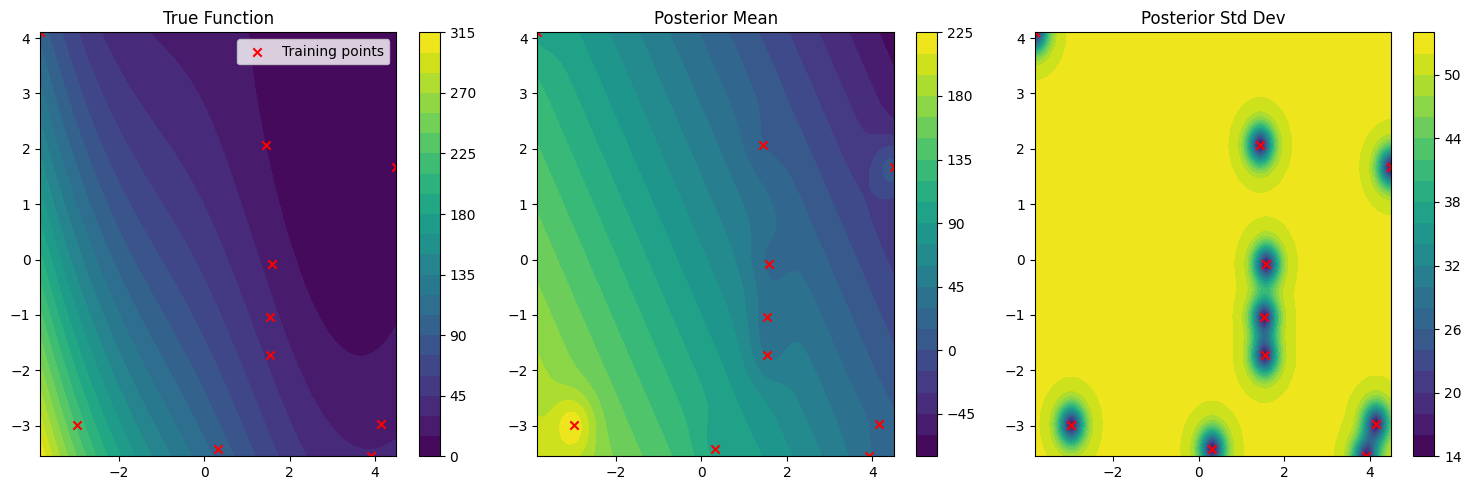

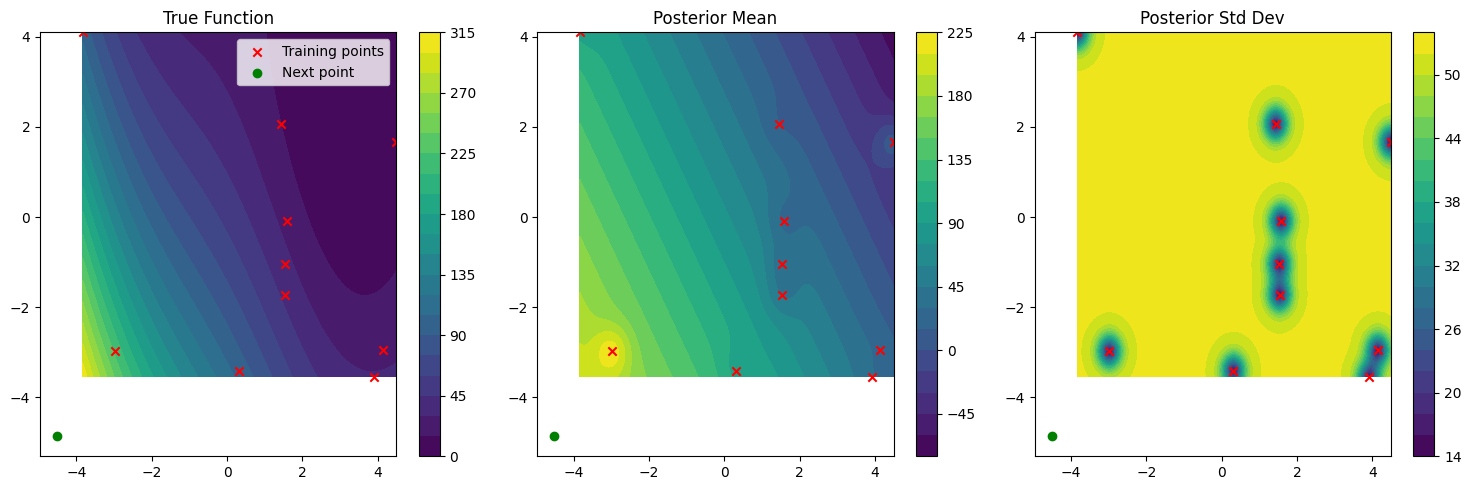

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


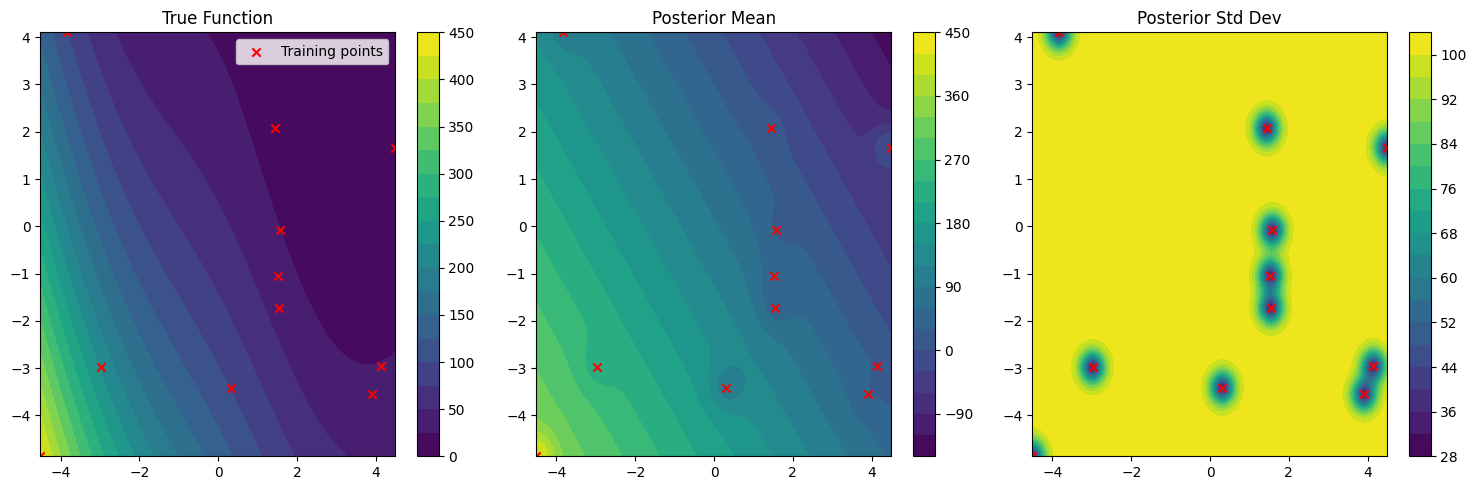

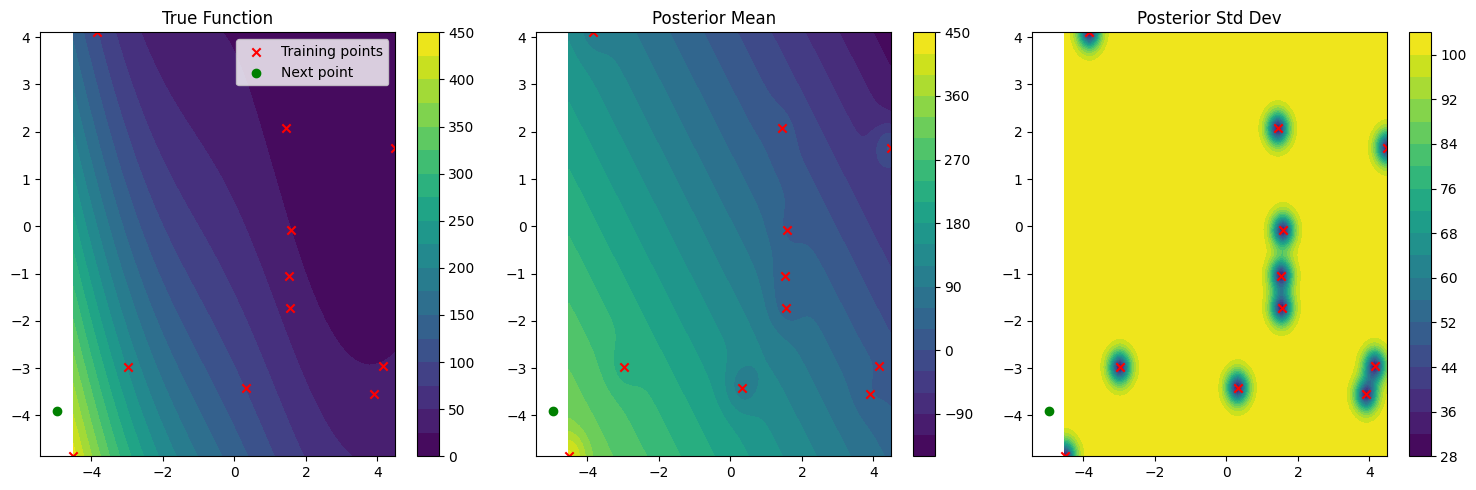

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


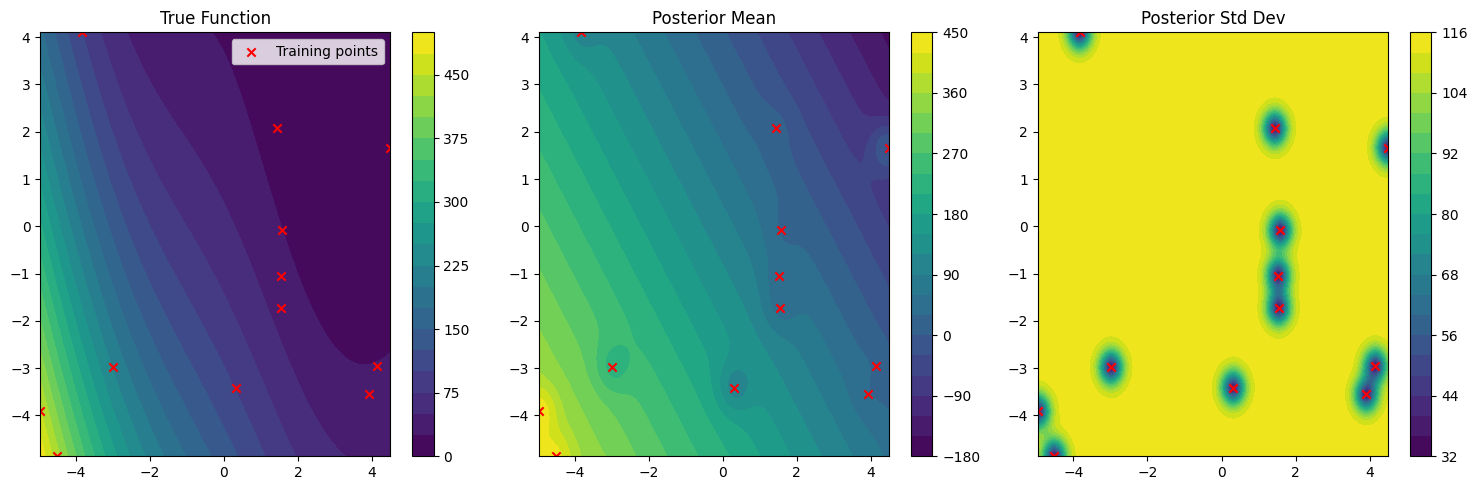

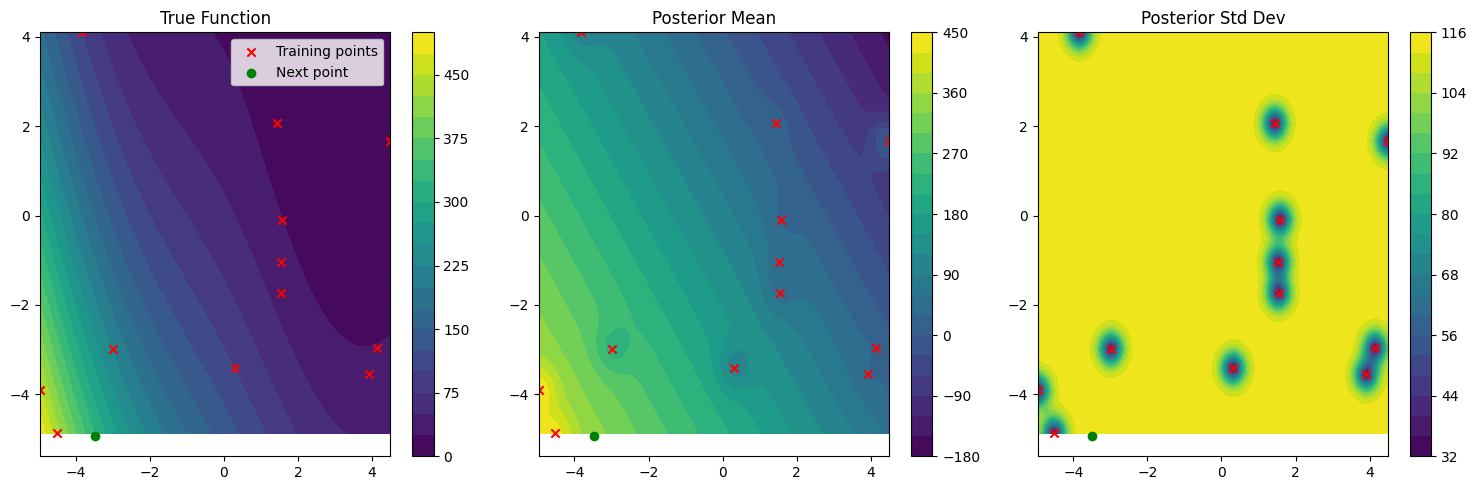

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


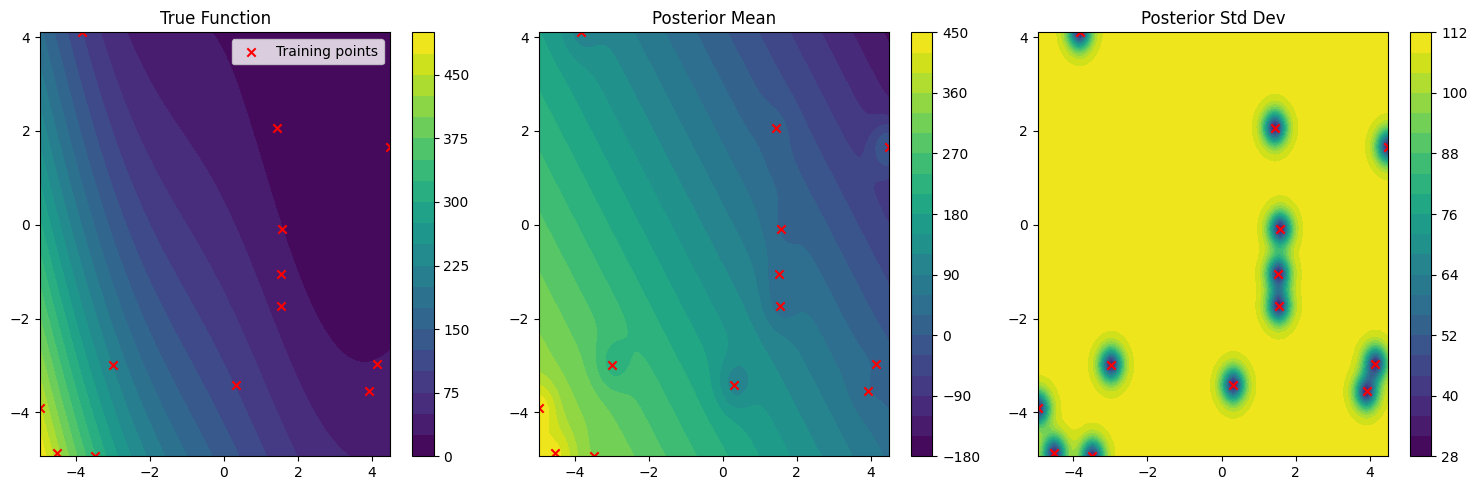

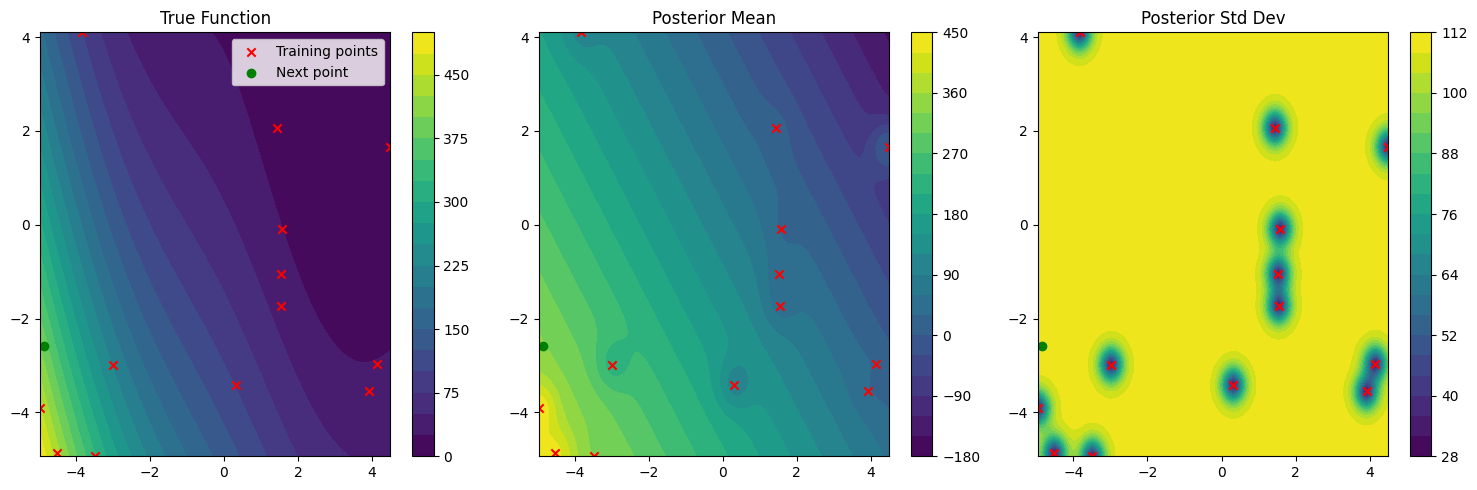

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


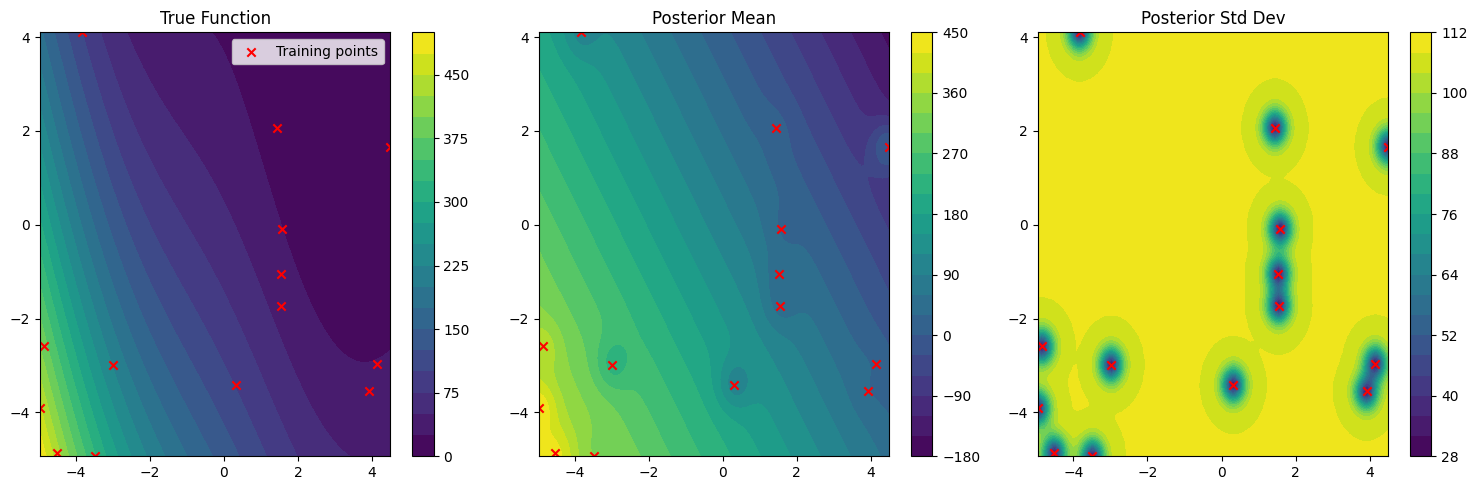

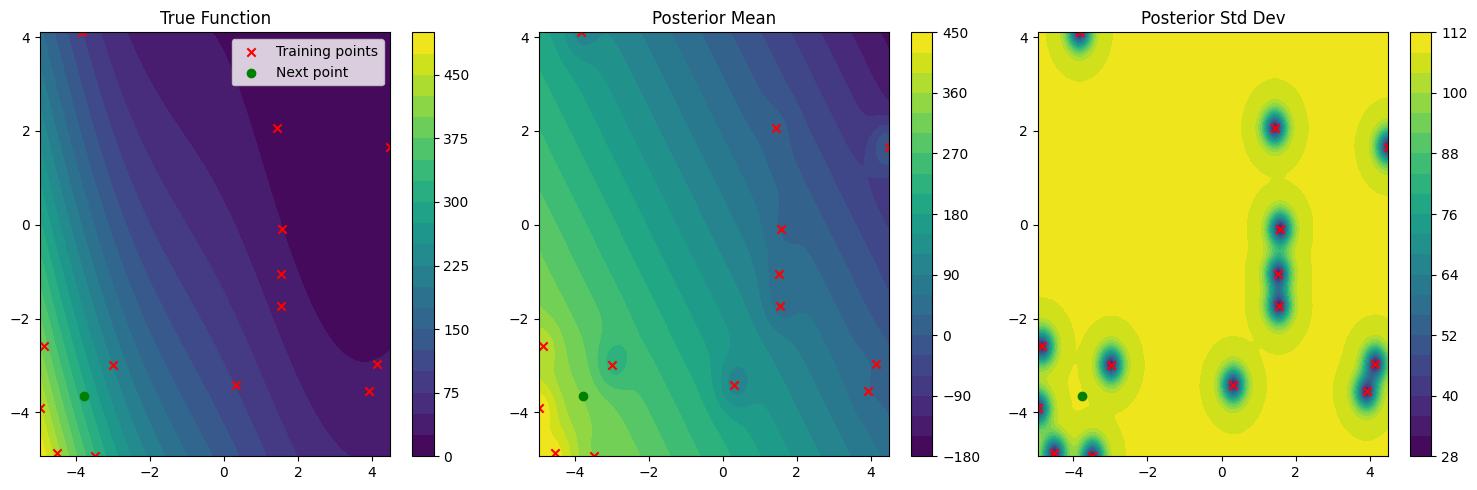

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


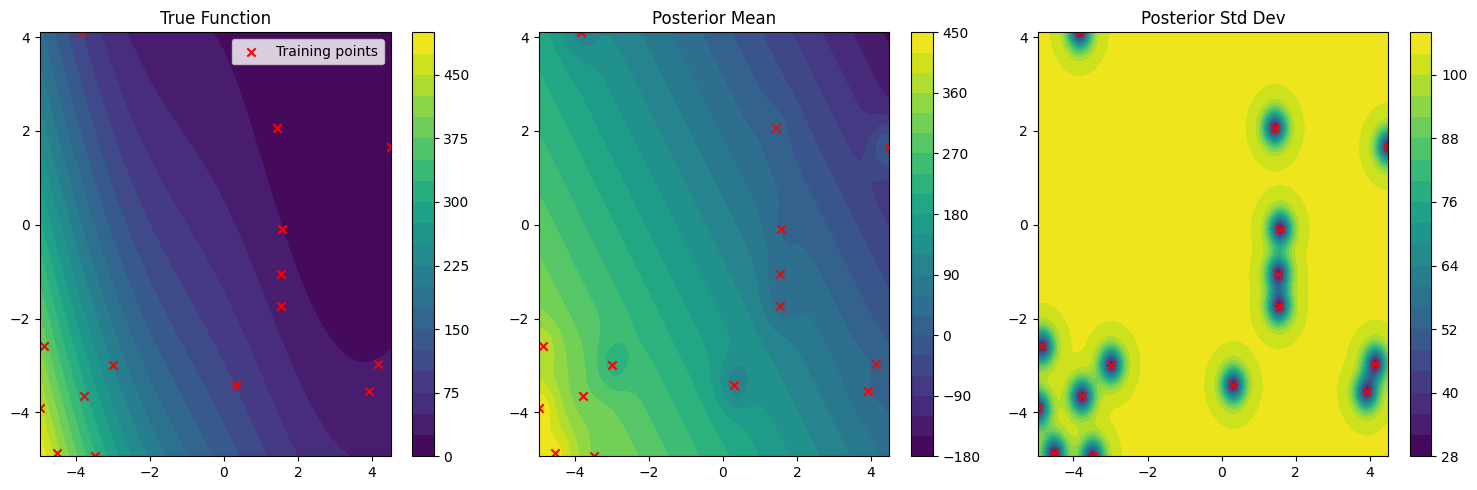

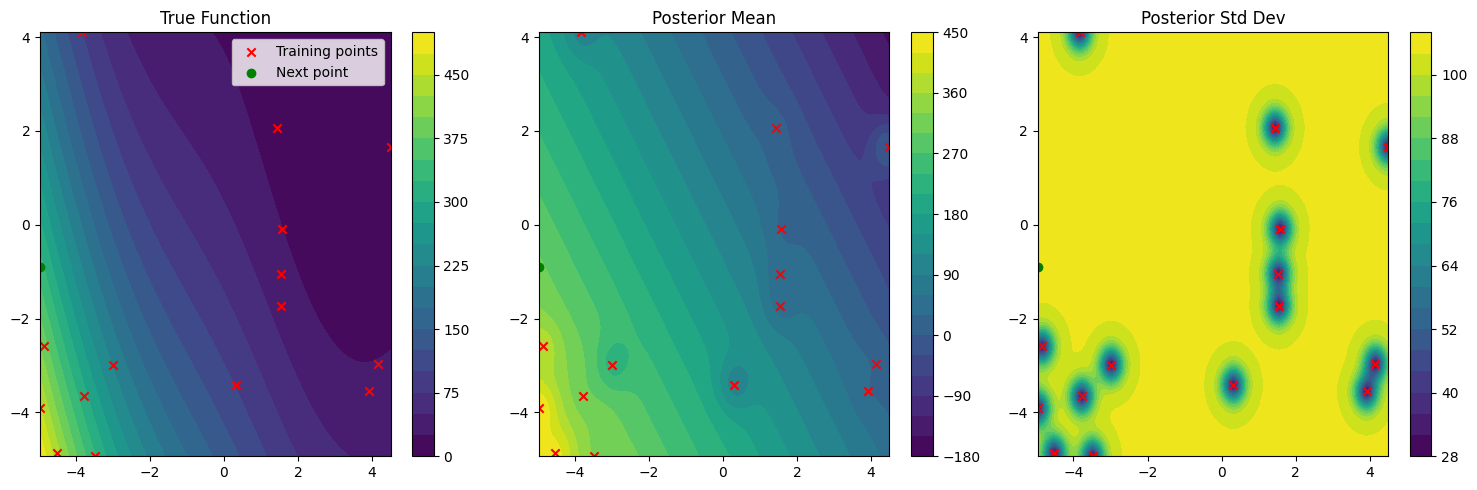

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


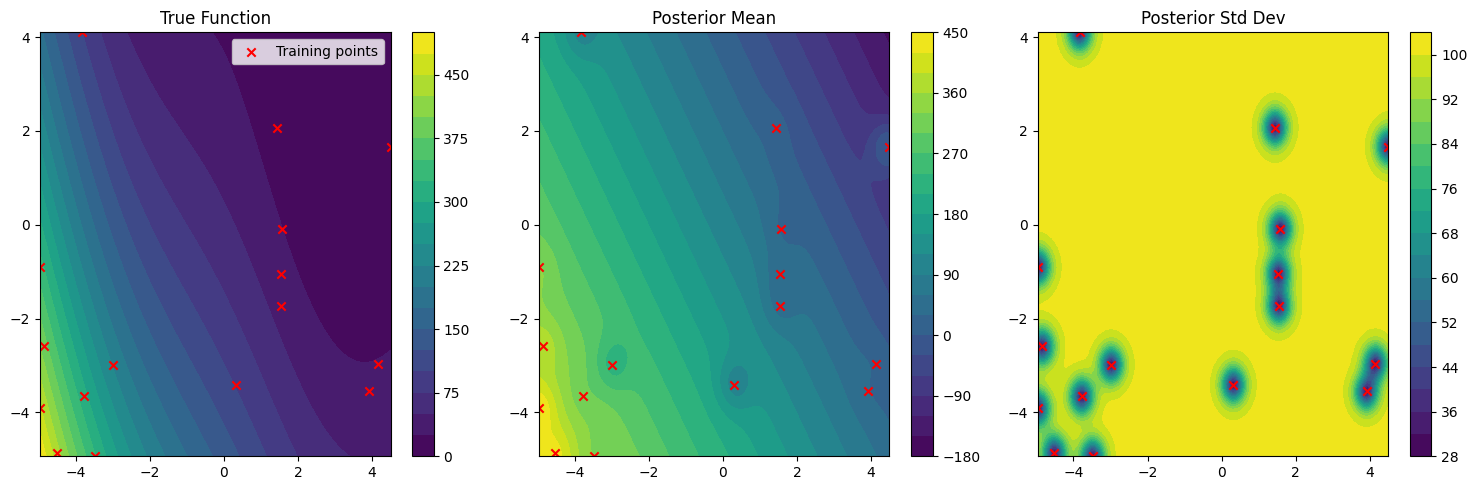

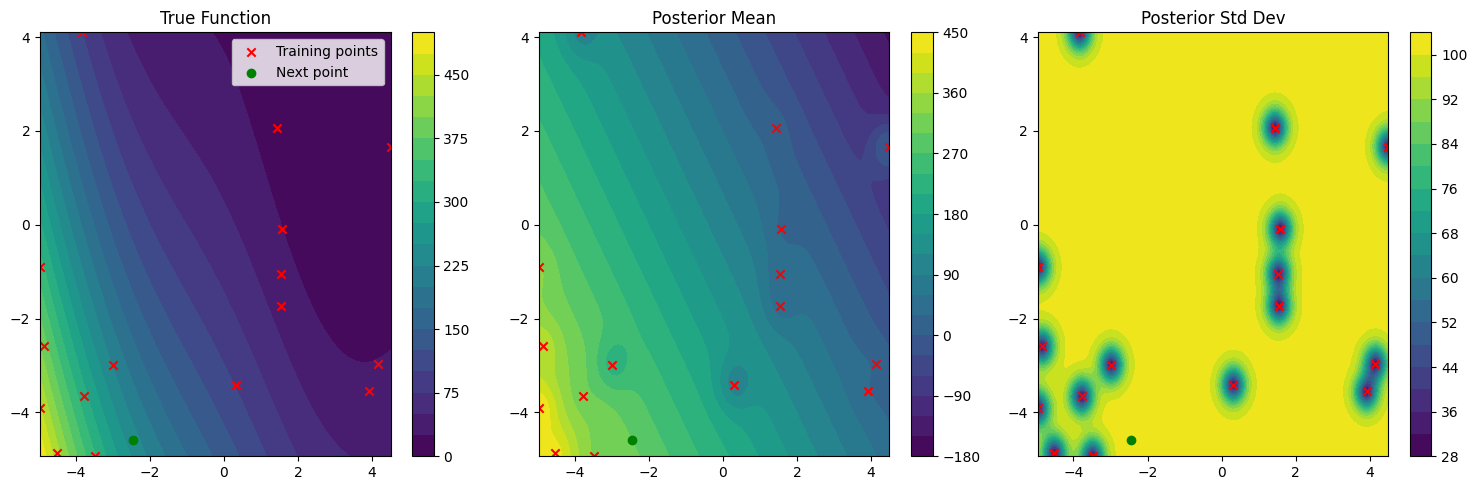

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


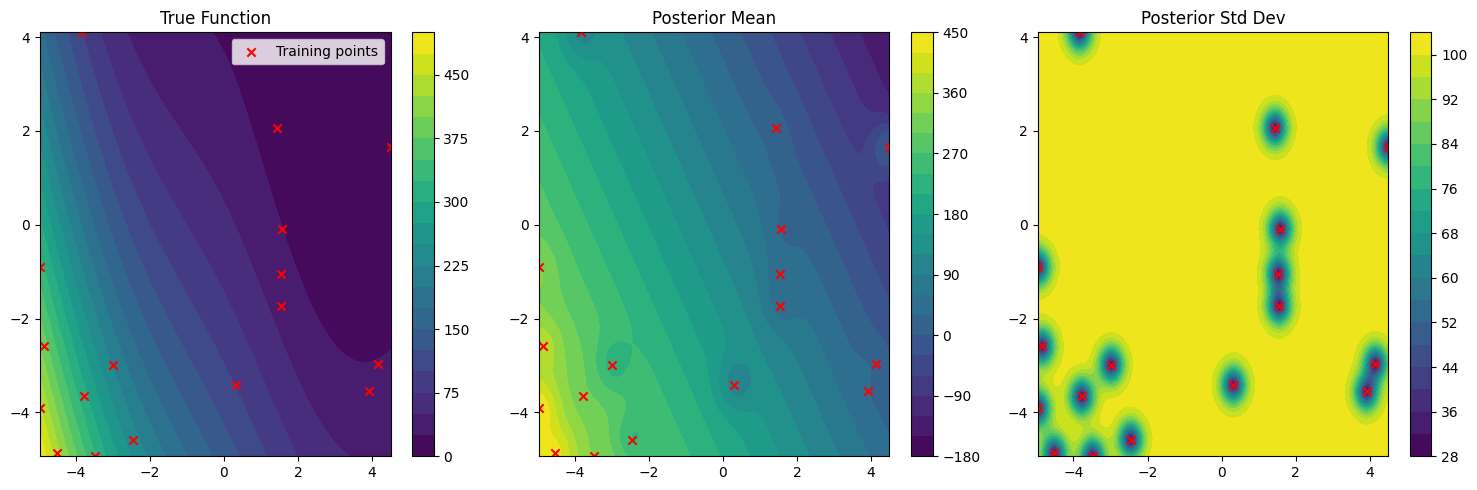

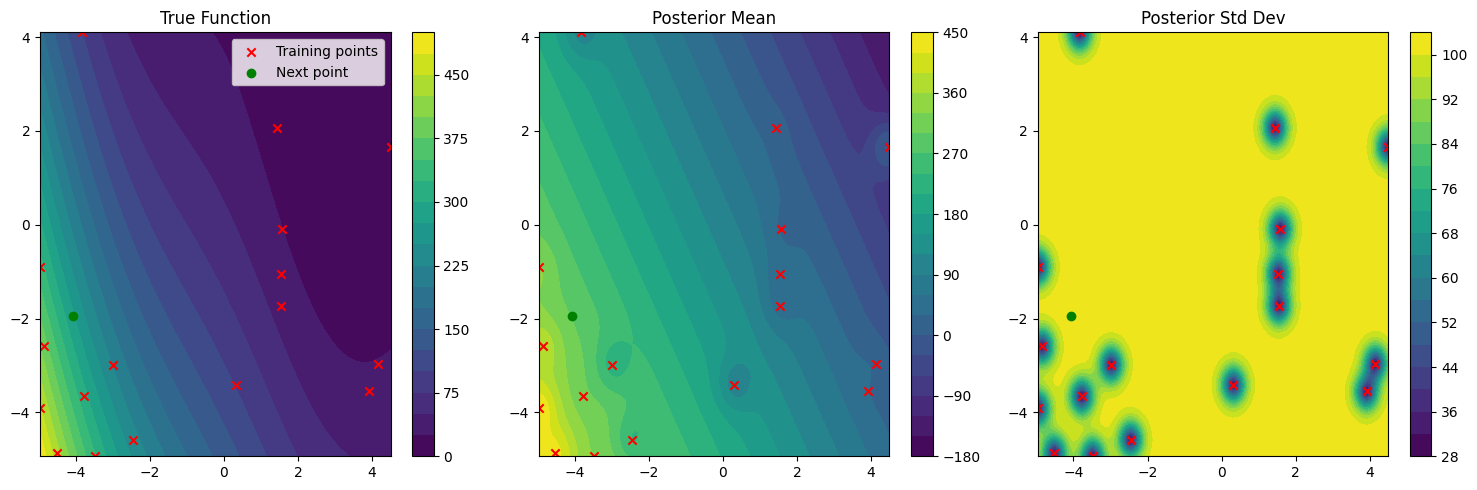

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


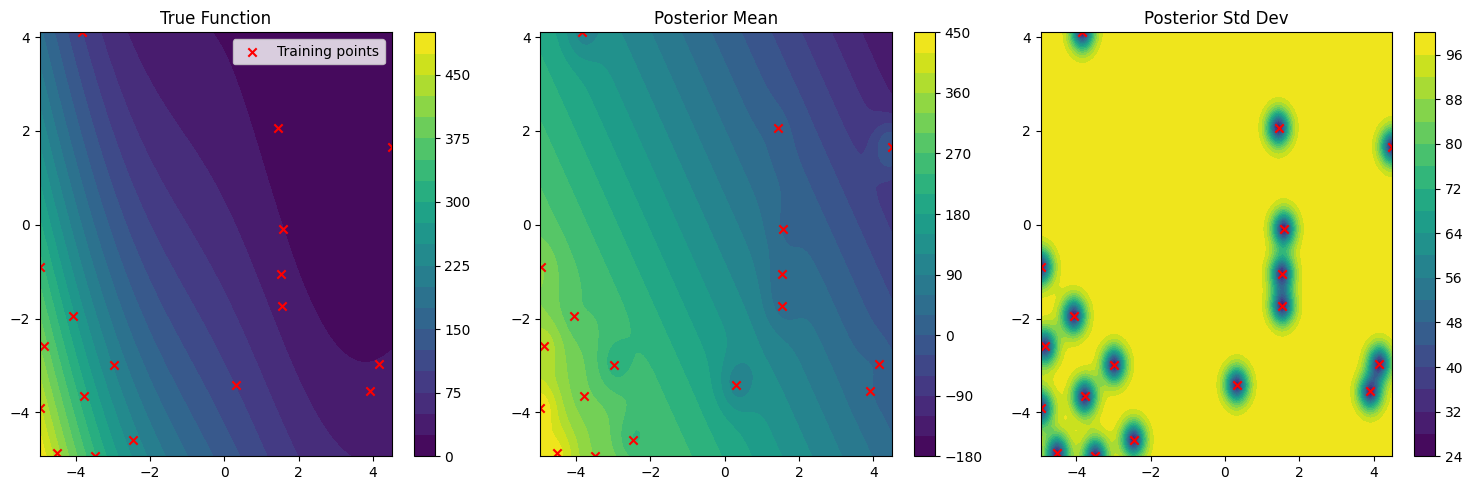

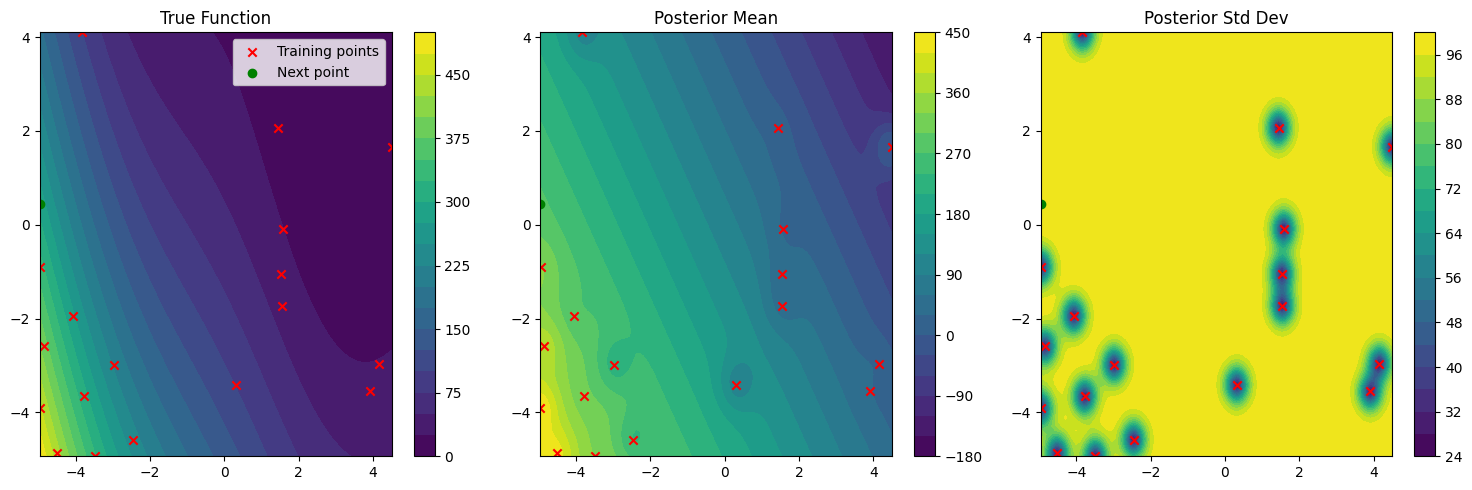

<ipython-input-9-1dcbe5d6e4d9>:4: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(train_X, train_Y)
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


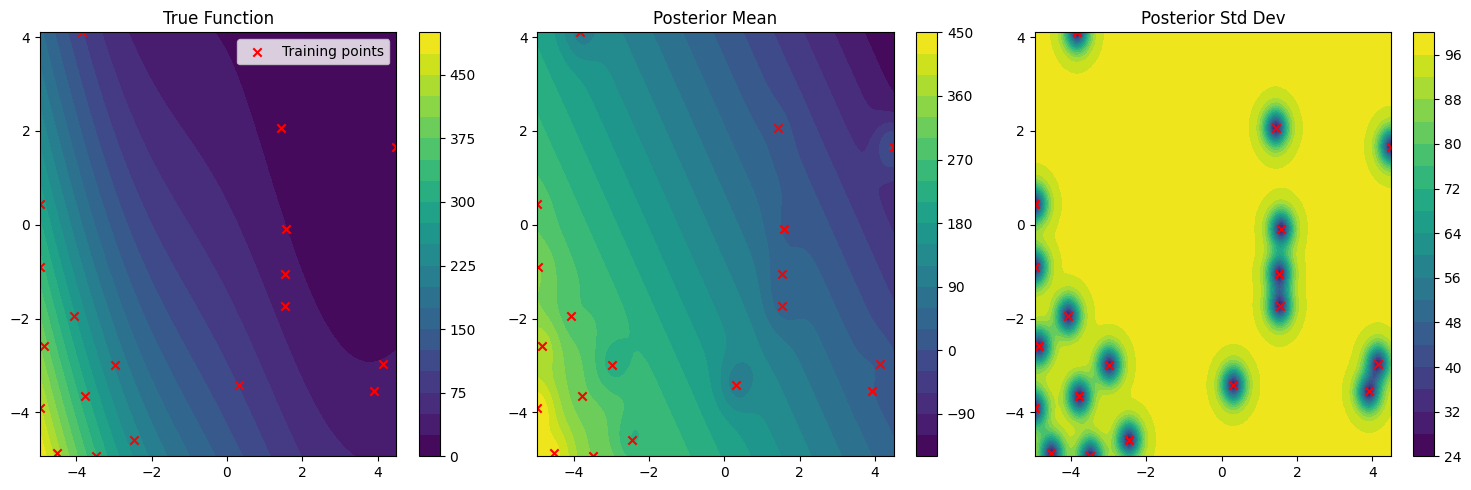

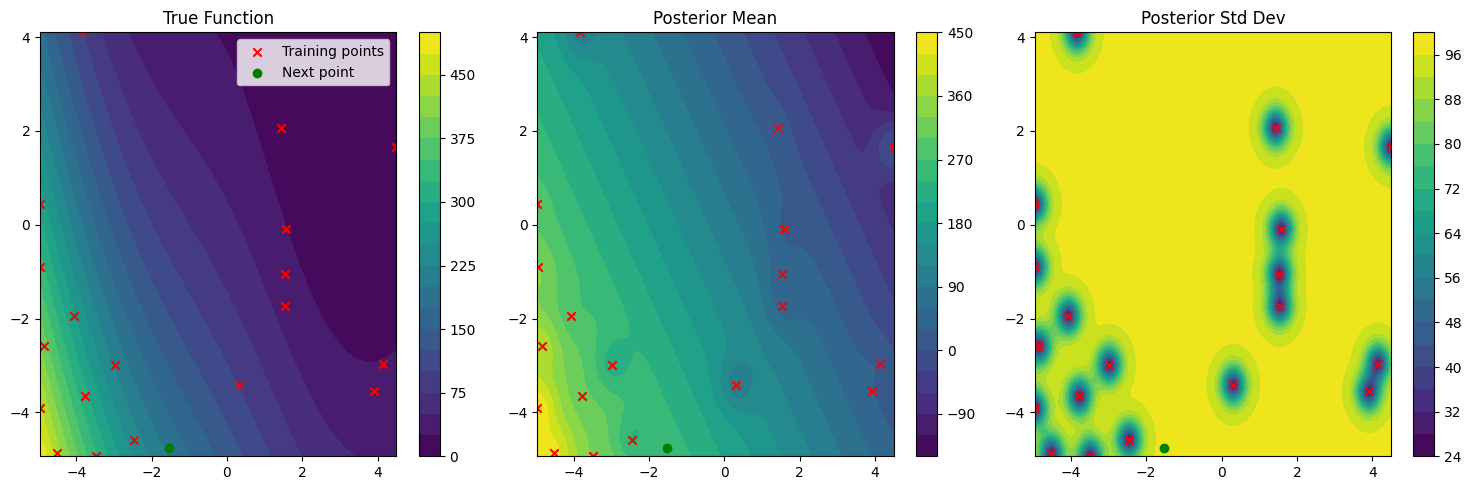

In [ ]:
# Parameters
ndim = 2
n_initial = 10
n_iterations = 10
beta = 1e6### --> higher means more exploration

# Generate initial data
train_X = sample_points(ndim, n_initial)
train_Y = test_function(train_X, ndim).unsqueeze(-1)  # Add extra dimension here --> so concatenation works fine in the loop

# Generate candidate points for discrete optimization
n_candidates = 1000
candidates = sample_points(ndim, n_candidates)

for iteration in range(n_iterations):
    # Define priors
    lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0)
    outputscale_prior = gpytorch.priors.GammaPrior(2.0, 0.15)
    noise_prior = gpytorch.priors.GammaPrior(1.1, 0.05)

    # Define model components
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior)
    mean_module = CustomMean(ndim)
    covar_module = CustomKernel(
        ndim,
        lengthscale_prior=lengthscale_prior,
        outputscale_prior=outputscale_prior
    )

    # Initialize and fit model
    model = CustomGP(train_X, train_Y.squeeze(-1), mean_module, covar_module, likelihood)  # Squeeze here for CustomGP
    mll = ExactMarginalLogLikelihood(likelihood, model)
    fit_gpytorch_mll(mll)

    # Plot current state
    plot_step(model, train_X, train_Y.squeeze(-1), ndim=ndim)  # Squeeze for plotting

    # Define acquisition function (UCB with beta=1e6)
    UCB = UpperConfidenceBound(model, beta=beta)

    # Optimize acquisition function
    next_point, acq_value = optimize_acqf_discrete(
        acq_function=UCB,
        choices=candidates,
        q=1,
    )

    # Plot with next point
    plot_step(model, train_X, train_Y.squeeze(-1), next_point, ndim=ndim)  # Squeeze for plotting

    # Evaluate next point and update training data
    next_value = test_function(next_point, ndim).unsqueeze(-1)  # Add extra dimension
    train_X = torch.cat([train_X, next_point])
    train_Y = torch.cat([train_Y, next_value])  # Now dimensions match